### ⚽️ French Football First League prediction 

In [15]:
#lib import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
df_2425 = pd.read_csv("./season-2425.csv")
df_2324 = pd.read_csv("./season-2324.csv")

#lets merge the two datasets
df_combined = pd.concat([df_2324, df_2425], ignore_index=True)

#anomalies in the data
#missing columns
print("Colonnes manquantes dans chaque dataset :")
print("2324 :", set(df_2425.columns) - set(df_2324.columns))
print("2425 :", set(df_2324.columns) - set(df_2425.columns))

#missing values
missing_values = df_combined.isnull().sum()
print("\nValeurs manquantes par colonne :")
print(missing_values[missing_values > 0])

#doubles
duplicates = df_combined.duplicated().sum()
print("\nNombre de lignes dupliquées :", duplicates)

#inconsistencies
invalid_results = df_combined[
    (df_combined["FTHG"] < 0) | (df_combined["FTAG"] < 0) | 
    (df_combined["HTHG"] < 0) | (df_combined["HTAG"] < 0) |
    (~df_combined["FTR"].isin(["H", "A", "D"]))
]

if not invalid_results.empty:
    print("\nAnomalies détectées dans les résultats :")
    print(invalid_results)

#save
df_combined.to_csv("ligue1_merged.csv", index=False)

print("\nMerge and verification successful .")


Now that we have our dataset, let's get rid of the data we won't need or which are not relevant for our study 

In [17]:
df = pd.read_csv("./data/ligue1_merged.csv")

# columns to drop
columns_to_drop = ["Date", "HTHG", "HTAG", "HTR", "Referee"]


df = df.drop(columns=columns_to_drop)

# Display the first few rows of the cleaned dataset
print(df.head())

    HomeTeam AwayTeam  FTHG  FTAG FTR  HS  AS  HST  AST  HF  AF  HC  AC  HY  \
0       Nice    Lille     1     1   D   8  12    3    5  13   9   3   3   3   
1  Marseille    Reims     2     1   H  14  11    4    4   7  16  10  10   1   
2   Paris SG  Lorient     0     0   D  20   4    4    0   8   6   9   2   0   
3      Brest     Lens     3     2   H  15  10    8    2  13  15   6   8   2   
4   Clermont   Monaco     2     4   A  15  14    7    8   7  16   6   2   0   

   AY  HR  AR  
0   2   0   0  
1   3   0   0  
2   0   0   0  
3   3   0   1  
4   4   0   0  


In [ ]:
# Set style
sns.set(style="whitegrid")

# résultats des matchs (Full Time Result - FTR)
plt.figure(figsize=(6, 4))
sns.countplot(x=df["FTR"], palette="pastel")
plt.title("Matches' Results Distribution")
plt.xlabel("Results (H = Home Win, A = Away Win, D = Draw)")
plt.ylabel("Number of matches")
plt.show()

# répartition des équipes à domicile
plt.figure(figsize=(8, 5))
sns.countplot(y=df["HomeTeam"], order=df["HomeTeam"].value_counts().index, palette="coolwarm")
plt.title("Frequency of Home Teams")
plt.xlabel("Number of home matches")
plt.ylabel("Team")
plt.xticks(rotation=45)
plt.show()

# répartition des équipes à l'extérieur
plt.figure(figsize=(8, 5))
sns.countplot(y=df["AwayTeam"], order=df["AwayTeam"].value_counts().index, palette="coolwarm")
plt.title("Frequency of Away Teams")
plt.xlabel("Number of away matches")
plt.ylabel("Team")
plt.xticks(rotation=45)
plt.show()

# buts marqués par match
plt.figure(figsize=(6, 4))
sns.histplot(df["FTHG"], bins=6, kde=True, color="blue", label="Home Goals", alpha=0.6)
sns.histplot(df["FTAG"], bins=6, kde=True, color="red", label="Away Goals", alpha=0.6)
plt.title("Goals Distribution")
plt.xlabel("Number of Goals")
plt.ylabel("Number of Matches")
plt.legend()
plt.show()

# nombre de tirs et tirs cadrés
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df["HS"], y=df["HST"], color="blue", label="Home Shots")
sns.scatterplot(x=df["AS"], y=df["AST"], color="red", label="Away Shots")
plt.title("Shots vs Shots on Target")
plt.xlabel("Total Shots")
plt.ylabel("Shots on Target")
plt.xlim(0, 40)
plt.ylim(0, 20)
plt.axhline(y=0, color='k', linestyle='--')
plt.legend()
plt.show()

# fautes commises par l'équipe à domicile et à l'extérieur
plt.figure(figsize=(6, 6))
plt.pie([df["HF"].sum(), df["AF"].sum()], labels=["Home Fouls", "Away Fouls"], autopct='%1.1f%%', colors=["blue", "red"])
plt.title("Distribution of Fouls")
plt.show()

# cartons rouges et jaunes
plt.figure(figsize=(6, 6))
plt.pie([df["HY"].sum(), df["AY"].sum(), df["HR"].sum(), df["AR"].sum()], 
        labels=["Home Yellow Cards", "Away Yellow Cards", "Home Red Cards", "Away Red Cards"],
        autopct='%1.1f%%', colors=["yellow", "orange", "darkred", "red"])
plt.title("Distribution of Cards")
plt.show()

In [21]:
# Transformation des résultats en classes (0 = Défaite, 1 = Nul, 2 = Victoire)
def result_to_class(result):
    if result == "H":
        return 2  # Victoire de l'équipe à domicile
    elif result == "D":
        return 1  # Match nul
    else:
        return 0  # Défaite de l'équipe à domicile

In [25]:
df["Match_Result"] = df["FTR"].apply(result_to_class)
y = df["Match_Result"].values

# Normalisation des features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Division train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Création du modèle MLP
model = tf.keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=(X.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dense(3, activation="softmax")  # 3 classes : victoire, nul, défaite
])

# Compilation du modèle
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# Évaluation du modèle
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Prédictions
y_pred = np.argmax(model.predict(X_test), axis=1)


Epoch 1/50


/Users/chloelarroze/doc/Sport_prediction/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3134 - loss: 1.1639 - val_accuracy: 0.5000 - val_loss: 1.0024
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5284 - loss: 1.0036 - val_accuracy: 0.5182 - val_loss: 0.9502
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5871 - loss: 0.9283 - val_accuracy: 0.5818 - val_loss: 0.9162
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6418 - loss: 0.8584 - val_accuracy: 0.5818 - val_loss: 0.8878
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6699 - loss: 0.8548 - val_accuracy: 0.5636 - val_loss: 0.8844
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6330 - loss: 0.8165 - val_accuracy: 0.5727 - val_loss: 0.8794
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6731 - loss: 0.7804 - val_accuracy: 0.5818 - val_loss: 0.8606
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6883 - loss: 0.7754 - val_accuracy: 0.5636 - val_loss: 0.8698
Epo

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x13ecc1940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


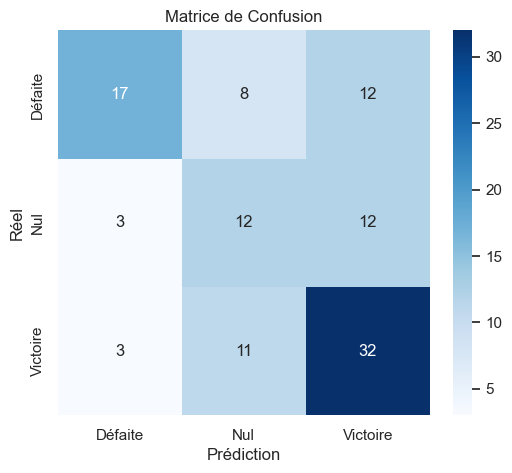

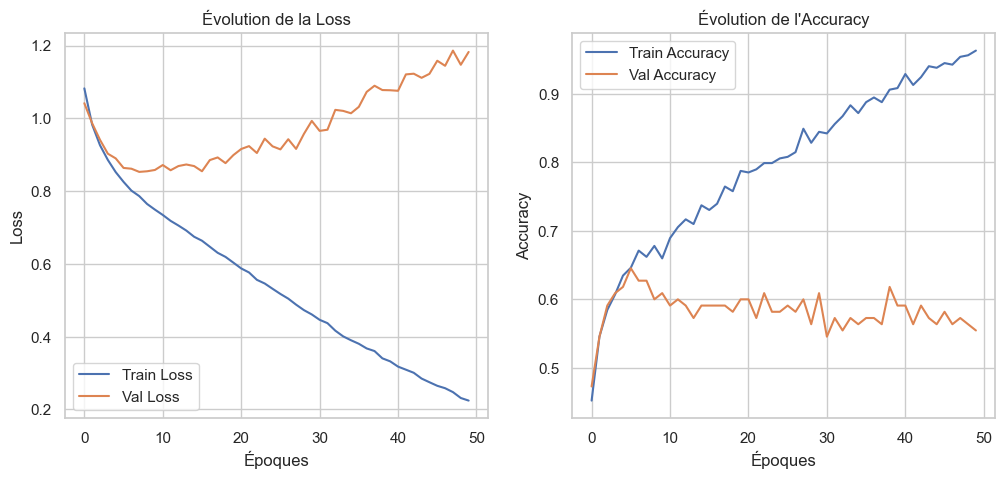

In [ ]:
# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Défaite", "Nul", "Victoire"], yticklabels=["Défaite", "Nul", "Victoire"])
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.title("Matrice de Confusion")
plt.show()